

# NLP From Scratch: Translation with a Transformer Network

Tutorial adapted from [NLP From Scratch with PyTorch by Sean Robertson](https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html), and [Tensorflow Tutorial on Transformers](https://www.tensorflow.org/text/tutorials/transformer)

In this tutorial, we will write our own classes and
functions to preprocess the data to do our NLP modeling tasks.
We hope after you complete this tutorial that you'll proceed to
learn how `torchtext` can handle much of this preprocessing for you.

In this project we will be teaching a neural network to translate from
French to English.

    [KEY: > input, = target, < output]

    > il est en train de peindre un tableau .
    = he is painting a picture .
    < he is painting a picture .

    > pourquoi ne pas essayer ce vin delicieux ?
    = why not try that delicious wine ?
    < why not try that delicious wine ?

    > elle n est pas poete mais romanciere .
    = she is not a poet but a novelist .
    < she not not a poet but a novelist .

    > vous etes trop maigre .
    = you re too skinny .
    < you re all alone .

... to varying degrees of success.

This is made possible by the simple but powerful idea of the [sequence
to sequence network](https://arxiv.org/abs/1409.3215)_, in which two neural
networks work together to transform one sequence to
another. An encoder network condenses an input sequence into a vector,
and a decoder network unfolds that vector into a new sequence.

![Image of a Sequence to Sequence model](https://pytorch.org/tutorials/_images/seq2seq.png)

To improve upon this model we'll use an [attention
mechanism](https://arxiv.org/abs/1409.0473)_, which lets the decoder
learn to focus over a specific range of the input sequence.

**Recommended Reading on Sequence to Sequence networks:**

-  [Learning Phrase Representations using RNN Encoder-Decoder for
   Statistical Machine Translation](https://arxiv.org/abs/1406.1078)_
-  [Sequence to Sequence Learning with Neural
   Networks](https://arxiv.org/abs/1409.3215)_
-  [Neural Machine Translation by Jointly Learning to Align and
   Translate](https://arxiv.org/abs/1409.0473)_
-  [A Neural Conversational Model](https://arxiv.org/abs/1506.05869)_

**Import Requirements**



In [1]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import re
import random
import numpy as np

import tensorflow as tf

/Users/admin/GitHub/nn/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


## Loading and preparing the data

The data for this project is a set of many thousands of English to
French translation pairs.
Let's start by downloading the data to ``data/eng-fra.txt``.
This file is a tab separated list of translation pairs:

`I am cold.    J'ai froid.`




In [2]:
import requests
from zipfile import ZipFile
from io import BytesIO

def download_and_unzip(url, extract_to='.'):
    """
    Downloads a ZIP file from the given URL and unzips it to the given directory.

    Parameters:
    url (str): The URL to download the ZIP file from.
    extract_to (str): The directory to extract the contents of the ZIP file to.
    """

    try:
        # Send a GET request to the URL
        print(f"Downloading file from {url}")
        response = requests.get(url)
        response.raise_for_status()

        # Extract all the contents of the zip file in the directory 'extract_to'
        with ZipFile(BytesIO(response.content)) as zip_file:
            print(f"Extracting contents to {extract_to}")
            zip_file.extractall(path=extract_to)
            print("Extraction completed.")
    except requests.exceptions.HTTPError as http_err:
        print(f"HTTP error occurred: {http_err}")  # Python 3.6
    except Exception as err:
        print(f"An error occurred: {err}")

download_and_unzip('https://download.pytorch.org/tutorial/data.zip', '.')

print('\nFirst 10 lines of the file:')
!head data/eng-fra.txt

Extracting contents to .
Extraction completed.

First 10 lines of the file:
Go.	Va !
Run!	Cours !
Run!	Courez !
Wow!	Ça alors !
Fire!	Au feu !
Help!	À l'aide !
Jump.	Saute.
Stop!	Ça suffit !
Stop!	Stop !
Stop!	Arrête-toi !


We will now process the data into pairs of french and english sentences.
The full process for preparing the data is:
 - Read the text file, split each line into pairs (the pairs are tab separated)
 - Pre-process all sentences, and filter by length and content
 - Split sentences into list of words, create two dictionaries (for english and french).

**Simplifications:**
   - The files are all in Unicode, we will turn Unicode characters to ASCII, make everything lowercase, and trim most punctuation.
   - Since we want to train something quickly, we'll trim the data set to only relatively short (10 word maximum) and simple sentences (starting with "I am" or "She is" ).

In [3]:
# Turn a Unicode string to plain ASCII, thanks to
# https://stackoverflow.com/a/518232/2809427
def unicode2ascii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters
def preprocess_string(s):
    s = unicode2ascii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z!?]+", r" ", s)
    return s.strip()

MAX_LENGTH = 10
ENG_PREFIXES = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s ",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)

# Filter pairs
def filter_pairs(pairs):
    subset = []
    for fr, en in pairs:
        if len(fr.split(' ')) > MAX_LENGTH:
            continue
        if len(en.split(' ')) > MAX_LENGTH:
            continue
        if not en.startswith(ENG_PREFIXES):
            continue
        subset.append((fr, en))
    return subset


# Read the data
def read_dataset(lang1, lang2, reverse=False):

    # Read the file and split into lines
    print("Reading lines...")
    lines = open('data/%s-%s.txt' % (lang1, lang2), encoding='utf-8').\
        read().strip().split('\n')

    # Split every line into pairs and normalize
    print("Processing lines...")
    pairs = [[preprocess_string(s) for s in l.split('\t')] for l in lines]

    # Reverse pairs
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]

    # Filter pairs by length and content
    pairs = filter_pairs(pairs)

    print("Finished processing")
    return pairs

corpus_pairs = read_dataset('eng', 'fra', reverse=True)

print(f"\nFound {len(corpus_pairs)} translation pairs.")
print("Here are 10 examples")
for _ in range(10):
    fr, en = random.choice(corpus_pairs)
    print(f"French: {fr} -> English: {en}")

Reading lines...
Processing lines...
Finished processing

Found 12038 translation pairs.
Here are 10 examples
French: vous etes endurant -> English: you re resilient
French: elles parlent en francais -> English: they re speaking french
French: vous etes la personne la plus importante dans ma vie -> English: you are the most important person in my life
French: je parle bien japonais -> English: i m good at japanese
French: vous etes la chef -> English: you re the leader
French: je suis trop vieux pour elle -> English: i m too old for her
French: j ai super faim -> English: i m super hungry
French: je ne me sens pas seul -> English: i m not lonely
French: je suis celui qui prend les decisions -> English: i m the one who makes the decisions
French: je suis en train de mediter -> English: i m meditating



<style>
td {
  text-align: center;
}

th {
  text-align: center;
}
</style>

We'll need a unique index per word to use as the inputs and targets of
the networks later. To keep track of all this we will use a helper class
called ``Lang`` which has word → index (``word2index``) and index → word
(``index2word``) dictionaries, as well as a count of each word
``word2count`` which will be used to replace rare words later.



In [4]:
SOS_token = 0
EOS_token = 1

class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {"PAD": 0, "SOS": 1, "EOS": 2, "UNK": 3}
        self.index2word = {0: "PAD", 1: "SOS", 2: "EOS", 3: "UNK"}
        self.word2count = {}
        self.n_words = 4  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

    def tokenize(self, sentence, seq_len=None):
        # Add Start Of Sentence token
        token_seq_idx = [self.word2index["SOS"]]

        # Tokenize each word in sentence
        for tkn in sentence.split():
            token_seq_idx.append(self.word2index[tkn if tkn in self.word2index else "UNK"])

        # Add End Of Sentence token
        token_seq_idx.append(self.word2index["EOS"])

        if seq_len is not None:
            if len(token_seq_idx) < seq_len:
                # Pad to desired lengh
                token_seq_idx += [self.word2index["PAD"]] * (seq_len - len(token_seq_idx))
            else:
                # Trim sentence to length
                token_seq_idx = token_seq_idx[:seq_len]

        return token_seq_idx

    def list2sentence(self, seq_ids):
        return " ".join([self.index2word[idx] for idx in seq_ids])


print("Creating French and English dictionaries.")
fr_vocab = Lang('fr')
en_vocab = Lang('en')
for fr, en in corpus_pairs:
    fr_vocab.addSentence(fr)
    en_vocab.addSentence(en)

print(f"French: {fr_vocab.n_words} words found.")
print(f"English: {en_vocab.n_words} words found.")

Creating French and English dictionaries.
French: 4771 words found.
English: 3111 words found.


In [5]:
def create_dataloaders(batch_size):
    # Create two huge tensors with all English and French sentences(+2 for START/END)
    n = len(corpus_pairs)
    french_seqs_ids = []
    english_seqs_ids = []
    for fr, en in corpus_pairs:
        french_seqs_ids.append(fr_vocab.tokenize(fr,MAX_LENGTH+2))
        english_seqs_ids.append(en_vocab.tokenize(en,MAX_LENGTH+2))
    french_seqs_ids = tf.convert_to_tensor(french_seqs_ids)
    english_seqs_ids = tf.convert_to_tensor(english_seqs_ids)

    # Split into training and testing
    train_sample_mask = tf.random.uniform((n,)) > 0.3
    train_french_seqs_ids = french_seqs_ids[train_sample_mask]
    train_english_seqs_ids = english_seqs_ids[train_sample_mask]
    test_french_seqs_ids = french_seqs_ids[~train_sample_mask]
    test_english_seqs_ids = english_seqs_ids[~train_sample_mask]

    # Create train dataset
    train_dataset = tf.data.Dataset.from_tensor_slices((train_french_seqs_ids, train_english_seqs_ids))
    train_dataset = train_dataset.shuffle(buffer_size=len(train_french_seqs_ids)).batch(batch_size)

    # Create test dataset
    test_dataset = tf.data.Dataset.from_tensor_slices((test_french_seqs_ids, test_english_seqs_ids))
    test_dataset = test_dataset.batch(batch_size)

    return train_dataset, test_dataset

# Test the dataloader
train_dataloader, test_dataloader = create_dataloaders(32)
for fr, en in train_dataloader.take(1):
    print('Batch | fr =', fr.shape, '| en =', en.shape)
    print('First sentence in French: ', fr[0].numpy())
    print('First sentence in English:', en[0].numpy())
    break


Batch | fr = (32, 12) | en = (32, 12)
First sentence in French:  [   1   31   32  335  183 1151  278    2    0    0    0    0]
First sentence in English: [   1    4    5  152  118  533 1632    2    0    0    0    0]


# Neural machine translation with a Transformer and Keras

This tutorial demonstrates how to create and train a [sequence-to-sequence](https://developers.google.com/machine-learning/glossary#sequence-to-sequence-task) [Transformer](https://developers.google.com/machine-learning/glossary#Transformer) model to translate French into English. The Transformer was originally proposed in ["Attention is all you need"](https://arxiv.org/abs/1706.03762) by Vaswani et al. (2017).


Transformers are deep neural networks that replace CNNs and RNNs with [self-attention](https://developers.google.com/machine-learning/glossary#self-attention). Self attention allows Transformers to easily transmit information across the input sequences.

As explained in the [Google AI Blog post](https://ai.googleblog.com/2017/08/transformer-novel-neural-network.html):

> Neural networks for machine translation typically contain an encoder reading the input sentence and generating a representation of it. A decoder then generates the output sentence word by word while consulting the representation generated by the encoder. The Transformer starts by generating initial representations, or embeddings, for each word... Then, using self-attention, it aggregates information from all of the other words, generating a new representation per word informed by the entire context, represented by the filled balls. This step is then repeated multiple times in parallel for all words, successively generating new representations.

<img src="https://www.tensorflow.org/images/tutorials/transformer/apply_the_transformer_to_machine_translation.gif" alt="Applying the Transformer to machine translation">

Figure 1: Applying the Transformer to machine translation. Source: [Google AI Blog](https://ai.googleblog.com/2017/08/transformer-novel-neural-network.html).


## Why Transformers are significant

- Transformers excel at modeling sequential data, such as natural language.
- Unlike the [recurrent neural networks (RNNs)](./text_generation.ipynb), Transformers are parallelizable. This makes them efficient on hardware like GPUs and TPUs. The main reasons is that Transformers replaced recurrence with attention, and computations can happen simultaneously. Layer outputs can be computed in parallel, instead of a series like an RNN.
- Unlike [RNNs](https://www.tensorflow.org/guide/keras/rnn) (like [seq2seq, 2014](https://arxiv.org/abs/1409.3215)) or [convolutional neural networks (CNNs)](https://www.tensorflow.org/tutorials/images/cnn) (for example, [ByteNet](https://arxiv.org/abs/1610.10099)), Transformers are able to capture distant or long-range contexts and dependencies in the data between distant positions in the input or output sequences. Thus, longer connections can be learned. Attention allows each location to have access to the entire input at each layer, while in RNNs and CNNs, the information needs to pass through many processing steps to move a long distance, which makes it harder to learn.
- Transformers make no assumptions about the temporal/spatial relationships across the data. This is ideal for processing a set of objects (for example, [StarCraft units](https://www.deepmind.com/blog/alphastar-mastering-the-real-time-strategy-game-starcraft-ii)).

<img src="https://www.tensorflow.org/images/tutorials/transformer/encoder_self_attention_distribution.png" width="800" alt="Encoder self-attention distribution for the word it from the 5th to the 6th layer of a Transformer trained on English-to-French translation">

Figure 3: The encoder self-attention distribution for the word “it” from the 5th to the 6th layer of a Transformer trained on English-to-French translation (one of eight attention heads). Source: [Google AI Blog](https://ai.googleblog.com/2017/08/transformer-novel-neural-network.html).


There's a lot going on inside a Transformer. The important things to remember are:

1. It follows the same general pattern as a standard sequence-to-sequence model with an encoder and a decoder. The encoder processes the input sentence into a set of vector representations (one for each word), and the decoder uses the encoder's outputs to predict the target (ie, translated) sentence.
2. If you work through it step by step it will all make sense.

<table>
<tr>
  <th colspan=1>The original Transformer diagram</th>
  <th colspan=1>A representation of a 4-layer Transformer</th>
</tr>
<tr>
  <td>
   <img width=400 src="https://www.tensorflow.org/images/tutorials/transformer/transformer.png"/>
  </td>
  <td>
   <img width=307 src="https://www.tensorflow.org/images/tutorials/transformer/Transformer-4layer-compact.png"/>
  </td>
</tr>
</table>

Each of the components in these two diagrams will be explained next. Namely,
- Embedding and positional encoding layer
- Add & Norm layer
- Multi-Head Attention Layers
- Feed Forward Layers

<table>
<tr>
<th colspan=1>The embedding and positional encoding layer</th>
<tr>
<tr>
<td>
<img src="https://www.tensorflow.org/images/tutorials/transformer/PositionalEmbedding.png"/>
</td>
</tr>
</table>

The inputs to both the encoder and decoder use the same embedding and positional encodings.

First, given a sequence of tokens, both the input tokens (French) and target tokens (English) have to be converted into vectors using a `tf.keras.layers.Embedding` layer.

Second, since attention layers see their input as an unordered set of vectors, it needs some way to identify word order. Otherwise, sentences like, `how are you`, `how you are`, `you how are`, and so on, would be indistinguishable. A Transformer adds a "Positional Encoding" to the embedding vectors. Positional Encodings are just vectors that uniquely identify word position. Also, ideally, nearby words should have similar position encodings.

The original paper uses a set of sines and cosines with different frequencies (across the sequence) for calculating the positional encoding

$$\Large{PE_{(pos, 2i)} = \sin(pos / 10000^{2i / d_{model}})} $$
$$\Large{PE_{(pos, 2i+1)} = \cos(pos / 10000^{2i / d_{model}})} $$


Position Encodings: (Max Position, Embedding Size) = (2048, 512)


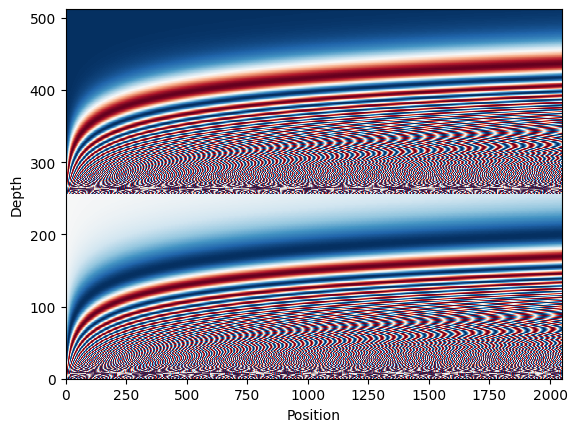

In [6]:
@tf.function
def positional_encoding(length, depth):
  depth = depth/2

  positions = np.arange(length)[:, np.newaxis]     # (seq, 1)
  depths = np.arange(depth)[np.newaxis, :]/depth   # (1, depth)

  angle_rates = 1 / (10000**depths)         # (1, depth)
  angle_rads = positions * angle_rates      # (pos, depth)

  pos_encoding = np.concatenate(
      [np.sin(angle_rads), np.cos(angle_rads)],
      axis=-1)

  return tf.cast(pos_encoding, dtype=tf.float32)


pos_encoding = positional_encoding(length=2048, depth=512)

# Visualize Position Embeddings
import matplotlib.pyplot as plt
print("Position Encodings: (Max Position, Embedding Size) =", pos_encoding.shape)
plt.pcolormesh(pos_encoding.numpy().T, cmap='RdBu')
plt.ylabel('Depth')
plt.xlabel('Position')
plt.show()

To combine info about the word itself and the word location within the sequence, we create a WordPosEmbedding layer that looks-up a token’s embedding vector and adds the position vector. Since we are working with two different languages, we need to use two different token embeddings.

In [7]:
class WordPosEmbedding(tf.keras.layers.Layer):
  def __init__(self, vocab_size, d_model):
    super().__init__()
    self.d_model = d_model
    self.embedding = tf.keras.layers.Embedding(vocab_size, d_model, mask_zero=True)
    self.pos_encoding = tf.stop_gradient(positional_encoding(length=2048, depth=d_model))

  def compute_mask(self, *args, **kwargs):
    return self.embedding.compute_mask(*args, **kwargs)

  def call(self, x):
    length = x.shape[1]
    x = self.embedding(x)
    # This factor sets the relative scale of the embedding and positonal_encoding.
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x = x + self.pos_encoding[tf.newaxis, :length, :]
    return x


embed_fr = WordPosEmbedding(vocab_size=fr_vocab.n_words, d_model=512)
embed_en = WordPosEmbedding(vocab_size=en_vocab.n_words, d_model=512)

# Example usage: embed layer receives a batch of sequences of word indexes (ie, a matrix of size BxL where B is batch size and L sequence lenght)
en_sentence = 'i am awesome'
en_seq = tf.expand_dims(tf.constant([en_vocab.word2index[w] for w in en_sentence.split()], dtype=tf.int32), axis=0)
print(en_seq.shape)
en_tkn_seq = embed_en(en_seq)
print(en_tkn_seq.shape)

fr_sentence = 'je plaisante'
fr_seq = tf.expand_dims(tf.constant([fr_vocab.word2index[w] for w in fr_sentence.split()],  dtype=tf.int32), axis=0)
print(fr_seq.shape)
fr_tkn_seq = embed_fr(fr_seq)
print(fr_tkn_seq.shape)

(1, 3)
(1, 3, 512)
(1, 2)
(1, 2, 512)


<table>
<tr>
<th colspan=2>Add and normalize</th>
<tr>
<tr>
<td>
<img src="https://www.tensorflow.org/images/tutorials/transformer/Add+Norm.png"/>
</td>
</tr>
</table>

These "Add & Norm" blocks are scattered throughout the model. Each one just implements a residual connection and followed by a `LayerNormalization` layer.

The residual "Add & Norm" blocks are included so that training is efficient. The residual connection provides a direct path for the gradient (and ensures that vectors are **updated** by the attention layers instead of **replaced**), while the normalization maintains a reasonable scale for the outputs.


Attention layers are used throughout the model. These are all identical except for how the attention is configured. Each one contains a `layers.MultiHeadAttention`, a `layers.LayerNormalization` and a `layers.Add`.

<table>
<tr>
  <th colspan=2>The base attention layer</th>
<tr>
<tr>
  <td>
   <img src="https://www.tensorflow.org/images/tutorials/transformer/BaseAttention.png"/>
  </td>
</tr>
</table>

In [8]:
class BaseAttention(tf.keras.layers.Layer):
  def __init__(self, **kwargs):
    super().__init__()
    self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)
    self.layernorm = tf.keras.layers.LayerNormalization()
    self.add = tf.keras.layers.Add()

#### Attention refresher

Before you get into the specifics of each usage, here is a quick refresher on how attention works.

There are two inputs:

1. The query sequence; the sequence being processed; the sequence doing the attending (bottom).
2. The context sequence; the sequence being attended to (left).

The output has the same shape as the query-sequence.

<table>
<tr>
  <th colspan=1>The base attention layer</th>
</tr>
<tr>
  <td>
   <img width=430 src="https://www.tensorflow.org/images/tutorials/transformer/BaseAttention-new.png"/>
  </td>
</tr>
</table>

For an intuitive understanding of attention, the common comparison is that this operation is like a dictionary lookup.
A **fuzzy**, **differentiable**, **vectorized** dictionary lookup.

Here's a regular python dictionary, with 3 keys and 3 values being passed a single query.

```
d = {'color': 'blue', 'age': 22, 'type': 'pickup'}
result = d['color']
```

- The `query`s is what you're trying to find.
- The `key`s what sort of information the dictionary has.
- The `value` is that information.

When you look up a `query` in a regular dictionary, the dictionary finds the matching `key`, and returns its associated `value`.
The `query` either has a matching `key` or it doesn't.
You can imagine a **fuzzy** dictionary where the keys don't have to match perfectly.
If you looked up `d["species"]` in the dictionary above, maybe you'd want it to return `"pickup"` since that's the best match for the query.

An attention layer does a fuzzy lookup like this, but it's not just looking for the best key.
It combines the `values` based on how well the `query` matches each `key`.

How does that work? In an attention layer the `query`, `key`, and `value` are each vectors.
Instead of doing a hash lookup the attention layer combines the `query` and `key` vectors to determine how well they match, the "attention score".
The layer returns the average across all the `values`, weighted by the "attention scores".

Each location the query-sequence provides a `query` vector.
The context sequence acts as the dictionary. At each location in the context sequence provides a `key` and `value` vector.
The input vectors are not used directly, the `layers.MultiHeadAttention` layer includes `layers.Dense` layers to project the input vectors before using them.


There are three different types of attention layers used throughout the model. These are all identical except for how the attention is configured. Lets take a look at each one of them now.

<table>
<tr>
<th colspan=1>The cross attention layer</th>
<tr>
<tr>
<td>
<img src="https://www.tensorflow.org/images/tutorials/transformer/CrossAttention.png"/>
</td>
</tr>
</table>

At the literal center of the Transformer is the cross-attention layer. This layer connects the encoder and decoder.
It updates the decoder representations by attending to all encoder sequence. To implement this, you pass the target sequence `x` as the `query` and the `context` sequence as the `key/value` when calling the `mha` layer. Furthermore, since the queries can attend to the entire input sequence representation, obtained from the encoder, then no causal mask is applied.


In [9]:
class CrossAttention(BaseAttention):
  def call(self, x, context):
    attn_output, attn_scores = self.mha(
        query=x,
        key=context,
        value=context,
        return_attention_scores=True)

    # Cache the attention scores for plotting later.
    self.last_attn_scores = attn_scores

    x = self.add([x, attn_output])
    x = self.layernorm(x)

    return x

sample_ca = CrossAttention(key_dim=512, num_heads=2)
print('Batch of English Sentences:', en_tkn_seq.shape)
print('Batch of French Sentences:', fr_tkn_seq.shape)
print('Output of Cross-Attention:', sample_ca(en_tkn_seq, fr_tkn_seq).shape)

Batch of English Sentences: (1, 3, 512)
Batch of French Sentences: (1, 2, 512)
Output of Cross-Attention: (1, 3, 512)


The caricature below shows how information flows through this layer. For simplicity the residual connections are not shown.

The output length is the length of the `query` sequence, and not the length of the context `key/value` sequence.
The point is that each `query` location (english words in this example) can see all the `key/value` pairs in the context (input french words), but no information is exchanged between the queries.

<table>
<tr>
  <th>Each query sees the whole context.</th>
</tr>
<tr>
  <td>
   <img width=430 src="https://www.tensorflow.org/images/tutorials/transformer/CrossAttention-new.png"/>
  </td>
</tr>
</table>

<table>
<tr>
  <th colspan=1>The global self attention layer</th>
<tr>
<tr>
  <td>
   <img src="https://www.tensorflow.org/images/tutorials/transformer/SelfAttention.png"/>
  </td>
</tr>
</table>

This layer is responsible for processing the context sequence (french sentence), and propagating information along its length.

Since the context sequence is fixed while the translation is being generated, information is allowed to flow in both directions.

Before Transformers, models commonly used RNNs or CNNs to do this task. However, RNNs and CNNs have their limitations.

- The RNN allows information to flow all the way across the sequence, but it passes through many processing steps to get there (limiting gradient flow). These RNN steps have to be run sequentially and so the RNN is less able to take advantage of modern parallel devices.
- In the CNN each location can be processed in parallel, but it only provides a limited receptive field. The receptive field only grows linearly with the number of CNN layers,  You need to stack a number of Convolution layers to transmit information across the sequence ([Wavenet](https://arxiv.org/abs/1609.03499) reduces this problem by using dilated convolutions).

The global self attention layer on the other hand lets every sequence element directly access every other sequence element, with only a few operations, and all the outputs can be computed in parallel.

<table>
<tr>
  <th colspan=1>Bidirectional RNNs</th>
</tr>
<tr>
  <td>
   <img width=500 src="https://www.tensorflow.org/images/tutorials/transformer/RNN-bidirectional.png"/>
  </td>
</tr>
<tr>
  <th colspan=1>CNNs</th>
</tr>
<tr>
  <td>
   <img width=500 src="https://www.tensorflow.org/images/tutorials/transformer/CNN.png"/>
  </td>
</tr>
<tr>
  <th colspan=1>The global self attention layer</th>
</tr>
<tr>
  <td>
   <img width=500 src="https://www.tensorflow.org/images/tutorials/transformer/SelfAttention-new.png"/>
  </td>
</tr>
</table>
</table>

To implement global self-attention you just need to pass the target sequence, `x`, as both the `query`, and `value` arguments to the `mha` layer:


In [10]:
class GlobalSelfAttention(BaseAttention):
  def call(self, x):
    attn_output = self.mha(
        query=x,
        value=x,
        key=x)
    x = self.add([x, attn_output])
    x = self.layernorm(x)

    return x

sample_gsa = GlobalSelfAttention(num_heads=2, key_dim=512,)

print('Batch of French Sentences:', fr_tkn_seq.shape)
print('Output of Global Self-Attention:', sample_gsa(fr_tkn_seq).shape)

Batch of French Sentences: (1, 2, 512)
Output of Global Self-Attention: (1, 2, 512)


<table>
<tr>
<th colspan=1>The causal self attention layer</th>
<tr>
<tr>
<td>
<img src="https://www.tensorflow.org/images/tutorials/transformer/CausalSelfAttention.png"/>
</td>
</tr>
</table>

This layer does a similar job as the global self attention layer, for the output sequence.
However, since we want to generate the output sequence word-by-word, the query sequence (ie, representing the english translation) can only attend to the previous (already generated) words: the models are "causal".

A causal model is efficient in two ways:

1. During training, we can feed the ground truth translation to the decoder input, and have it predict the very next token at all locations. This lets you compute loss for every location in the output sequence while executing the model just once.
2. During inference, for each new token generated you only need to calculate its outputs, the outputs for the previous sequence elements can be reused.

Causal attention is accomplished using a causal mask, which ensures that each location only has access to the locations that come before it:

<table>
<tr>
  <th colspan=1>The causal self attention layer</th>
<tr>
<tr>
  <td>
   <img width=330 src="https://www.tensorflow.org/images/tutorials/transformer/CausalSelfAttention-new-full.png"/>
  </td>
</tr>
  <td>
   <img width=430 src="https://www.tensorflow.org/images/tutorials/transformer/CausalSelfAttention-new.png"/>
  </td>
</tr>
</table>
</table>


To build a causal self attention layer, you need to use an appropriate mask when computing the attention scores and summing the attention `value`s.

This is taken care of automatically if you pass `use_causal_mask = True` to the `MultiHeadAttention` layer when you call it:





In [11]:
class CausalSelfAttention(BaseAttention):
  def call(self, x):
    attn_output = self.mha(
        query=x,
        value=x,
        key=x,
        use_causal_mask = True)

    x = self.add([x, attn_output])
    x = self.layernorm(x)

    return x


# Example usage
sample_csa = CausalSelfAttention(num_heads=2, key_dim=512)
print('Batch of English Sentences:', en_tkn_seq.shape)
print('Output of Causal Self-Attention:', sample_csa(en_tkn_seq).shape)

Batch of English Sentences: (1, 3, 512)
Output of Causal Self-Attention: (1, 3, 512)


<table>
<tr>
  <th colspan=1>The feed forward network</th>
<tr>
<tr>
  <td>
   <img src="https://www.tensorflow.org/images/tutorials/transformer/FeedForward.png"/>
  </td>
</tr>
</table>

The transformer also includes point-wise feed-forward networks, which process each token independently (no interactions between words), in both the encoder and decoder.


In [12]:
class FeedForward(tf.keras.layers.Layer):
  def __init__(self, d_model, dff, dropout_rate=0.1):
    super().__init__()
    self.seq = tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),
      tf.keras.layers.Dense(d_model),
      tf.keras.layers.Dropout(dropout_rate)
    ])
    self.add = tf.keras.layers.Add()
    self.layer_norm = tf.keras.layers.LayerNormalization()

  def call(self, x):
    x = self.add([x, self.seq(x)])
    x = self.layer_norm(x)

    return x

# Example usage
sample_ffnet = FeedForward(d_model=512, dff=4)
print('Batch of English Sentences:', en_tkn_seq.shape)
print('Output of Causal Self-Attention:', sample_ffnet(en_tkn_seq).shape)

Batch of English Sentences: (1, 3, 512)
Output of Causal Self-Attention: (1, 3, 512)


### The Encoder and Decoder

Now, that we know how each component of a Transformer model work, lets put them all together.

The encoder contains a `WordPosEmbedding` layer at the input and a stack of `N` encoder layers. Each `EncoderLayer` contains a `GlobalSelfAttention` and `FeedForward` layer.

<table>
<tr>
  <td>
   <img src="https://www.tensorflow.org/images/tutorials/transformer/Encoder.png"/>
  </td>
</tr>
</table>


In [13]:
class EncoderLayer(tf.keras.layers.Layer):
  def __init__(self,*, d_model, num_heads, dff, dropout_rate=0.1):
    super().__init__()

    self.self_attention = GlobalSelfAttention(
        num_heads=num_heads,
        key_dim=d_model,
        dropout=dropout_rate)

    self.ffn = FeedForward(d_model, dff)

  def call(self, x):
    x = self.self_attention(x)
    x = self.ffn(x)

    return x

sample_encoder_layer = EncoderLayer(d_model=512, num_heads=8, dff=2048)

print(fr_tkn_seq.shape)
print(sample_encoder_layer(fr_tkn_seq).shape)

(1, 2, 512)
(1, 2, 512)


In [14]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, *, num_layers, d_model, num_heads,
               dff, vocab_size, dropout_rate=0.1):
    super().__init__()

    self.d_model = d_model
    self.num_layers = num_layers

    self.pos_embedding = WordPosEmbedding(
        vocab_size=vocab_size, d_model=d_model)

    self.enc_layers = [
        EncoderLayer(d_model=d_model,
                     num_heads=num_heads,
                     dff=dff,
                     dropout_rate=dropout_rate)
        for _ in range(num_layers)]
    self.dropout = tf.keras.layers.Dropout(dropout_rate)

  def call(self, x):
    # `x` is token-IDs shape: (batch, seq_len)
    x = self.pos_embedding(x)  # Shape `(batch_size, seq_len, d_model)`.

    # Add dropout.
    x = self.dropout(x)

    for i in range(self.num_layers):
      x = self.enc_layers[i](x)

    return x  # Shape `(batch_size, seq_len, d_model)`.

# Example usage
sample_encoder = Encoder(num_layers=3, d_model=512, num_heads=8, dff=4, vocab_size=fr_vocab.n_words)
print('Batch of English Sentences:', fr_seq.shape)
print('Output of Causal Self-Attention:', sample_encoder(fr_seq).shape)

Batch of English Sentences: (1, 2)
Output of Causal Self-Attention: (1, 2, 512)


The decoder's stack starts with `WordPosEmbedding`, followed by a series of `DecoderLayer`, containing a `CausalSelfAttention`, a `CrossAttention`, and a `FeedForward` layer.

<table>
<tr>
  <td>
   <img src="https://www.tensorflow.org/images/tutorials/transformer/DecoderLayer.png"/>
  </td>
</tr>
</table>

In [15]:
class DecoderLayer(tf.keras.layers.Layer):
  def __init__(self,
               *,
               d_model,
               num_heads,
               dff,
               dropout_rate=0.1):
    super(DecoderLayer, self).__init__()

    self.causal_self_attention = CausalSelfAttention(
        num_heads=num_heads,
        key_dim=d_model,
        dropout=dropout_rate)

    self.cross_attention = CrossAttention(
        num_heads=num_heads,
        key_dim=d_model,
        dropout=dropout_rate)

    self.ffn = FeedForward(d_model, dff)

  def call(self, x, context):
    x = self.causal_self_attention(x=x)
    x = self.cross_attention(x=x, context=context)

    # Cache the last attention scores for plotting later
    self.last_attn_scores = self.cross_attention.last_attn_scores

    x = self.ffn(x)  # Shape `(batch_size, seq_len, d_model)`.

    return x

sample_decoder_layer = DecoderLayer(d_model=512, num_heads=8, dff=2048)

sample_decoder_layer_output = sample_decoder_layer(
    x=en_tkn_seq, context=fr_tkn_seq)

print(en_tkn_seq.shape)
print(fr_tkn_seq.shape)
print(sample_decoder_layer_output.shape)  # `(batch_size, seq_len, d_model)`

(1, 3, 512)
(1, 2, 512)
(1, 3, 512)


In [16]:
class Decoder(tf.keras.layers.Layer):
  def __init__(self, *, num_layers, d_model, num_heads, dff, vocab_size,
               dropout_rate=0.1):
    super(Decoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers

    self.pos_embedding = WordPosEmbedding(vocab_size=vocab_size,
                                             d_model=d_model)
    self.dropout = tf.keras.layers.Dropout(dropout_rate)
    self.dec_layers = [
        DecoderLayer(d_model=d_model, num_heads=num_heads,
                     dff=dff, dropout_rate=dropout_rate)
        for _ in range(num_layers)]

    self.last_attn_scores = None

  def call(self, x, context):
    # `x` is token-IDs shape (batch, target_seq_len)
    x = self.pos_embedding(x)  # (batch_size, target_seq_len, d_model)

    x = self.dropout(x)

    for i in range(self.num_layers):
      x  = self.dec_layers[i](x, context)

    self.last_attn_scores = self.dec_layers[-1].last_attn_scores

    # The shape of x is (batch_size, target_seq_len, d_model).
    return x

# Example usage
sample_decoder = Decoder(num_layers=3, d_model=512, num_heads=8, dff=4, vocab_size=fr_vocab.n_words)
print('Batch of French Sentences:', fr_seq.shape)
print('Batch of English Sentences:', en_seq.shape)
fr_feats = sample_encoder(fr_seq)
tgt_feats = sample_decoder(en_seq, fr_feats)
print('Output of Causal Self-Attention:', tgt_feats.shape)

Batch of French Sentences: (1, 2)
Batch of English Sentences: (1, 3)
Output of Causal Self-Attention: (1, 3, 512)


In [17]:
sample_decoder.last_attn_scores.shape  # (batch, heads, target_seq, input_seq)

TensorShape([1, 8, 3, 2])

In [18]:
class Transformer(tf.keras.Model):
  def __init__(self, *, num_layers, d_model, num_heads, dff,
               input_vocab_size, target_vocab_size, dropout_rate=0.1):
    super().__init__()
    self.encoder = Encoder(num_layers=num_layers, d_model=d_model,
                           num_heads=num_heads, dff=dff,
                           vocab_size=input_vocab_size,
                           dropout_rate=dropout_rate)

    self.decoder = Decoder(num_layers=num_layers, d_model=d_model,
                           num_heads=num_heads, dff=dff,
                           vocab_size=target_vocab_size,
                           dropout_rate=dropout_rate)

    self.final_layer = tf.keras.layers.Dense(target_vocab_size)

  def call(self, inputs):
    # If want to use keras `.fit` you must pass all your inputs as one
    x, context = inputs

    context = self.encoder(context)  # (batch_size, context_len, d_model)

    x = self.decoder(x, context)  # (batch_size, target_len, d_model)

    # Final linear layer output.
    logits = self.final_layer(x)  # (batch_size, target_len, target_vocab_size)

    # try:
    #   # Drop the keras mask, so it doesn't scale the losses/metrics.
    #   # b/250038731
    #   del logits._keras_mask
    # except AttributeError:
    #   pass

    # Return the final output and the attention weights.
    return logits


# Example usage
sample_transformer = Transformer(num_layers=3, d_model=512, num_heads=8, dff=4,
                          input_vocab_size=fr_vocab.n_words,
                          target_vocab_size=en_vocab.n_words)
print('Batch of French Sentences:', fr_seq.shape)
print('Batch of English Sentences:', en_seq.shape)
print('Output of Causal Self-Attention:', sample_transformer((fr_seq,en_seq)).shape)

Batch of French Sentences: (1, 2)
Batch of English Sentences: (1, 3)
Output of Causal Self-Attention: (1, 2, 3111)


## Evaluation

Evaluation is mostly the same as training, but there are no targets so
we simply feed the decoder's predictions back to itself for each step.
Every time it predicts a word we add it to the output string, and if it
predicts the EOS token we stop there.

We can evaluate random sentences from the training set and print out the
input, target, and output to make some subjective quality judgements.


In [19]:
import tqdm

def evaluate(transformer, fr_sentence):
  # The French sentence is tokenized and converted to a batch of B=1
  french_tkns = tf.expand_dims(tf.convert_to_tensor([fr_vocab.word2index[word] for word in fr_sentence.split()], dtype=tf.int32), axis=0)
  # First, the sentence to be translated is encoded using the transformer encoder.
  french_feats = transformer.encoder(french_tkns)

  # The translation sentence is initialized with SOS token
  decoded_tkns = tf.convert_to_tensor([[en_vocab.word2index['SOS']]], dtype=tf.int32)

  # We'll keep track of the predicted logits in order to compute the perplexity
  pred_logits = []

  # Then, we evaluate the decoder, to generate the next words in the translation, one word at a time.
  for _ in range(MAX_LENGTH - 1):

      next_pred_feat = transformer.decoder(decoded_tkns,french_feats)[:, -1]
      next_pred_logit = transformer.final_layer(next_pred_feat)
      next_pred = tf.expand_dims(tf.argmax(next_pred_logit, axis=1, output_type=tf.int32),axis=0)
      pred_logits.append(next_pred_logit)
      if next_pred.numpy()[0] == en_vocab.word2index['EOS']:
          break
      decoded_tkns = tf.concat([decoded_tkns, next_pred], axis=1)

  decoded_tkns = tf.squeeze(decoded_tkns, axis=0)  # Squeeze batch dimension
  translation_words = [en_vocab.index2word[idx.numpy()] for idx in decoded_tkns[1:]]
  pred_logits = tf.concat(pred_logits, axis=0)
  return translation_words, decoded_tkns, pred_logits


def evaluate_one_epoch(transformer, n=100):
  criterion = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
  loss, perplexity = 0.0, 0.0
  for i in tqdm.tqdm(range(n), desc='[EVAL]'):
    for fr_tkn, en_tkn in test_dataloader.shuffle(10).take(1):
      en_tkn = en_tkn[0].numpy()
      fr_tkn = fr_tkn[0].numpy()
      fr = fr_vocab.list2sentence(fr_tkn[en_tkn>2])
      _, _, pred_logits = evaluate(transformer, fr)
      l = criterion(en_tkn[1:1 + len(pred_logits)], pred_logits).numpy()
      loss += l
      perplexity += tf.exp(l)

  return loss / n, perplexity / n

def translate_randomly(transformer, n=3):
  for fr_tkn, en_tkn in test_dataloader.shuffle(10).take(n):
    en_tkn = en_tkn[0].numpy()
    fr_tkn = fr_tkn[0].numpy()

    en = en_vocab.list2sentence(en_tkn[en_tkn>2])
    fr = fr_vocab.list2sentence(fr_tkn[en_tkn>2])

    print('>', fr)
    print('=', en)
    output_sentence, _, _ = evaluate(transformer, fr)
    print('<', ' '.join(output_sentence))
    print('')

In [20]:
translate_randomly(sample_transformer)
loss, perplexity = evaluate_one_epoch(sample_transformer)
print('\n Loss = ', loss)
print('Perplexity = ', perplexity.numpy())

> je ne suis pas
= i m no hero
< novels desperate odd friendship suit match ignoring respectable bridge

> je suis sobre
= i m sober
< novels desperate course theft away house less jet snob

> je suis un puriste
= i m a purist
< novels desperate june photos parties natured want adventurous shirt


[EVAL]: 100%|██████████| 100/100 [01:30<00:00,  1.11it/s]


 Loss =  8.021713628768921
Perplexity =  3054.7932


## Training

To train, we use our typical training loop to optimize all weights of the model by gradient descent.
The transformer model receives as input batches of French and English sentence pairs. The encoder processes the French sentence globally, and the decoder processes the English sentence causally (only looking at previous tokens) while simultaneously attending to the encoder output.
The transformer finally outputs a prediction if the next word, at each point in the translation.
The model is trained to optimize the CrossEntropy loss (over the English dictionary) using the Adam optimizer.

In [21]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

def show_plot(points):
    plt.figure()
    fig, ax = plt.subplots()
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

def train_epoch(train_dataloader, transformer, optimizer, criterion):
  total_loss = 0
  for fr_tensor, en_tensor in train_dataloader:
    en_past = en_tensor[:, :-1]
    en_target = en_tensor[:, 1:]
    # print(en_past.shape, en_target.shape, fr_tensor.shape)

    with tf.GradientTape() as tape:
        preds = transformer((en_past,fr_tensor))
        loss = criterion(
            tf.reshape(en_target,[-1]),
            tf.reshape(preds,[-1, preds.shape[-1]]),
            )
    gradients = tape.gradient(loss, transformer.trainable_variables)
    optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))
    total_loss += loss.numpy()


  return total_loss/ len(list(train_dataloader))

def train(train_dataset, transformer, optimizer, n_epochs, print_every=5, plot_every=1):
    plot_losses = []
    criterion = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

    for epoch in tqdm.tqdm(range(n_epochs), desc='[TRAIN]'):
        loss = train_epoch(train_dataloader, transformer, optimizer, criterion)

        if epoch % print_every == 0:
            te_loss, te_perplexity = evaluate_one_epoch(transformer)
            print(f'[Epoch={epoch}/{n_epochs}] Training Loss={loss:.4f}. Test Loss = {te_loss:.4f}. Test Perplexity = {te_perplexity:.2f}')
            translate_randomly(transformer, n=3)

        if epoch % plot_every == 0:
            plot_losses.append(loss)

    show_plot(plot_losses)



[TRAIN]:   0%|          | 0/30 [00:00<?, ?it/s]WARNING:tensorflow:5 out of the last 5 calls to <function _BaseOptimizer._update_step_xla at 0x7a25a332c940> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.

[EVAL]: 100%|██████████| 100/100 [01:05<00:00,  1.52it/s]


[Epoch=0/30] Training Loss=3.4019. Test Loss = 4.6070. Test Perplexity = 101.53
> vous etes sournois
= you re sneaky
< m m m m m m m m m

> il est trop occupe
= he s too busy
< m m m m m m m m m

> nous ne nous battons
= we re not fighting


[TRAIN]:   3%|▎         | 1/30 [01:47<52:09, 107.93s/it]

< m m m m m m m m m


[EVAL]: 100%|██████████| 100/100 [00:49<00:00,  2.03it/s]


[Epoch=5/30] Training Loss=2.7645. Test Loss = 4.6128. Test Perplexity = 104.25
> nous sommes toutes celibataires
= we re all single
< i you you you

> c est toi le
= you re the oldest
< i you you you

> il est trop occupe
= he s too busy


[TRAIN]:  20%|██        | 6/30 [04:29<17:35, 43.99s/it]

< i you you you


[EVAL]: 100%|██████████| 100/100 [00:51<00:00,  1.94it/s]


[Epoch=10/30] Training Loss=2.0825. Test Loss = 7.9764. Test Perplexity = 5123.90
> c est toi le
= you re the oldest
< i m not not a one

> je suis de la ville
= i m from the city
< i m not not a one

> elles sont mauvaises
= they re bad


[TRAIN]:  37%|███▋      | 11/30 [07:29<13:39, 43.13s/it]

< i m not not a one


[EVAL]: 100%|██████████| 100/100 [00:44<00:00,  2.25it/s]


[Epoch=15/30] Training Loss=1.7993. Test Loss = 7.3395. Test Perplexity = 4342.38
> nous ne nous battons
= we re not fighting
< i m not a friend

> je suis de la ville
= i m from the city
< i m not a friend

> ca va EOS
= i m ok


[TRAIN]:  53%|█████▎    | 16/30 [09:57<08:49, 37.85s/it]

< i m not a friend


[EVAL]: 100%|██████████| 100/100 [00:45<00:00,  2.21it/s]


[Epoch=20/30] Training Loss=1.6842. Test Loss = 7.1801. Test Perplexity = 8442.76
> je suis de la ville
= i m from the city
< i m not a good friend

> ca va EOS
= i m ok
< i m not a good friend

> elles sont mauvaises
= they re bad


[TRAIN]:  70%|███████   | 21/30 [12:24<05:34, 37.12s/it]

< you re very brave


[EVAL]: 100%|██████████| 100/100 [00:50<00:00,  1.96it/s]


[Epoch=25/30] Training Loss=1.5098. Test Loss = 7.5411. Test Perplexity = 35153.68
> nous ne nous battons
= we re not fighting
< you re very sophisticated

> vous etes sournois
= you re sneaky
< you re very sophisticated

> je suis de la ville
= i m from the city


[TRAIN]:  87%|████████▋ | 26/30 [14:57<02:34, 38.62s/it]

< i m not a little good person


[TRAIN]: 100%|██████████| 30/30 [16:17<00:00, 32.59s/it]


<Figure size 640x480 with 0 Axes>

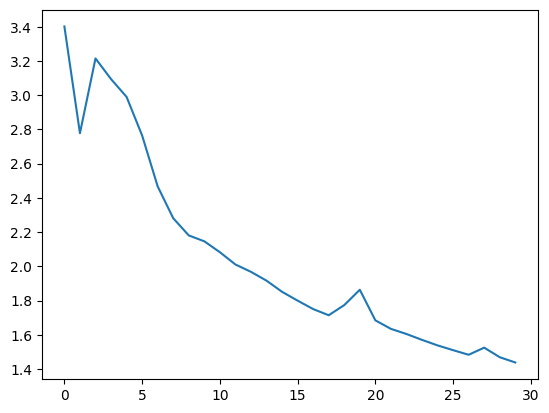

In [22]:
epochs = 30
batch_size = 128
num_layers = 2
learning_rate = 0.001
weight_decay = 0.0005

train_dataloader, test_dataloader = create_dataloaders(batch_size)

transformer = Transformer(num_layers=num_layers, d_model=256, num_heads=8, dff=4,
                          input_vocab_size=fr_vocab.n_words,
                          target_vocab_size=en_vocab.n_words)

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate, weight_decay=weight_decay)

train(train_dataloader, transformer, optimizer, epochs)

### Visualizing Attention

A useful property of the attention mechanism is its highly interpretable
outputs. Because it is used to weight specific encoder outputs of the
input sequence, we can imagine looking where the network is focused most
at each time step.

You could simply run ``plt.matshow(attentions)`` to see attention output
displayed as a matrix. For a better viewing experience we will do the
extra work of adding axes and labels:




In [42]:
def plot_attention_head(in_tokens, translated_tokens, attention):
  # The model didn't generate `<START>` in the output. Skip it.
  translated_tokens = translated_tokens[1:]

  ax = plt.gca()
  ax.matshow(attention)
  ax.set_xticks(range(len(in_tokens)))
  ax.set_yticks(range(len(translated_tokens)))

  labels = [label.decode('utf-8') for label in in_tokens.numpy()]
  ax.set_xticklabels(
      labels, rotation=90)

  labels = [label.decode('utf-8') for label in translated_tokens.numpy()]
  ax.set_yticklabels(labels)

input = il n est pas aussi grand que son pere
output = ['he', 'is', 'a', 'man', 'of', 'dogs']


<ipython-input-50-ab07eb3a0c09>:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[i].set_xticklabels([''] + input_sentence.split(' '), rotation=90)
<ipython-input-50-ab07eb3a0c09>:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[i].set_yticklabels([''] + output_words)


<Figure size 640x480 with 0 Axes>

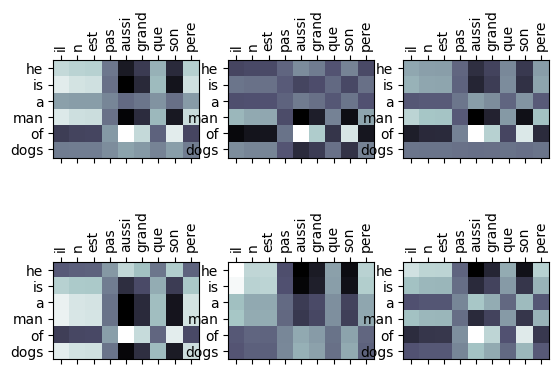

input = je suis trop fatigue pour conduire
output = ['i', 'm', 'not', 'a', 'little', 'hungry', 'person']


<Figure size 640x480 with 0 Axes>

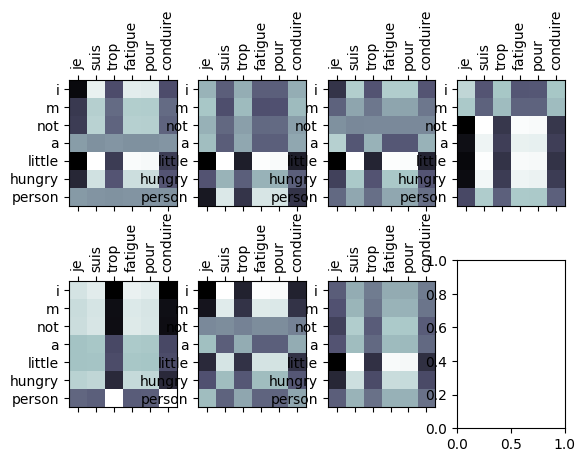

input = je suis desole si c est une question idiote
output = ['i', 'm', 'sorry', 'i', 'didn', 't', 'you', '?']


<Figure size 640x480 with 0 Axes>

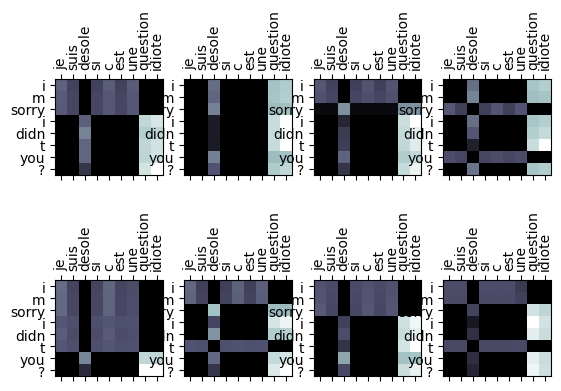

input = je suis reellement fiere de vous
output = ['i', 'm', 'not', 'a', 'little', 'hungry', 'person']


<Figure size 640x480 with 0 Axes>

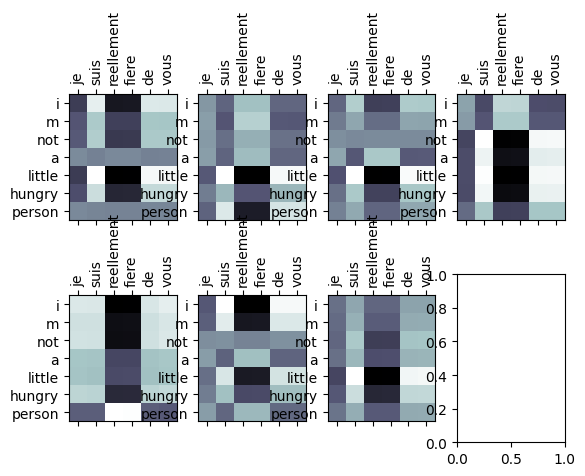

In [50]:
%matplotlib inline
import math
def showAttention(input_sentence, output_words, attentions):
    heads = attentions.shape[1]
    fig = plt.figure()
    fig, axs = plt.subplots(2,math.ceil(heads/2))

    axs = axs.ravel()
    for i in range(heads):

      axs[i].matshow(attentions[i], cmap='bone')

      # Set up axes
      axs[i].set_xticklabels([''] + input_sentence.split(' '), rotation=90)
      axs[i].set_yticklabels([''] + output_words)

      # # Show label at every tick
      # axs[i].xaxis.set_major_locator(ticker.MultipleLocator(1))
      # axs[i].yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

def evaluateAndShowAttention(input_sentence):
    output_sentence, _, _ = evaluate(transformer, input_sentence)
    attention_scores = transformer.decoder.last_attn_scores  # (batch, heads, target_seq, input_seq)
    print("="*30)
    print('input =', input_sentence)
    print('output =', output_sentence)

    showAttention(input_sentence, output_sentence, attention_scores[0, : , :len(output_sentence), :])


evaluateAndShowAttention('il n est pas aussi grand que son pere')

evaluateAndShowAttention('je suis trop fatigue pour conduire')

evaluateAndShowAttention('je suis desole si c est une question idiote')

evaluateAndShowAttention('je suis reellement fiere de vous')